In the current competition there seem to be only a few kernels (ok .. besides the kernel provided by the competition organisers and related forks) that use a DL classification model.

With this kernel I hope to add a little to the choices that are available and still provide a nice score given the GPU time available. Some keypoints of this kernel:
* Simple EfficientNet B2 model
* Custom head
* Custom sampling
* An attempt to detect when an object is no landmark by using a Places365 model. I'am using the same model as in my notebook during last years Landmark Recognition [Landmark Notebook](https://www.kaggle.com/rsmits/keras-landmark-or-non-landmark-identification)

If you liked this kernel then please give it an upvote :-)

I'am looking forward to any questions or remarks you might have that I can use to improve this kernel.

## Version Updates

Version 10:
* Increase image size to 256.
* Slightly lower Batch Size and Learning Rate.
* Lower the minimum sample threshold to include more classes.
* Add Label Smoothing
* Trained for 6 epochs on external M60 GPU VM.

Altough I trained on an external GPU server the code to run the training is updated in the notebook. The score is however then in Version 8. I suspect this is due to the Label Smoothing. I will try the next version without it.. to be continued..

In [1]:
# Import Modules
import albumentations as A
import cv2
import gc
import numpy as np
import os
import pandas as pd
import random
import sys
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer

# EfficientNet
!pip install '../input/glrec2020/Keras_Applications-1.0.8-py3-none-any.whl'
!pip install '../input/glrec2020/efficientnet-1.1.0-py3-none-any.whl'
import efficientnet.tfkeras as efn

# VGG 16 Places 365 scripts in custom dataset
os.chdir("../input/keras-vgg16-places365")
from vgg16_places_365 import VGG16_Places365
os.chdir("/kaggle/working/")

Processing /kaggle/input/glrec2020/Keras_Applications-1.0.8-py3-none-any.whl
Processing /kaggle/input/glrec2020/efficientnet-1.1.0-py3-none-any.whl


In [2]:
# Set All Random Stuff
SEED = 4249
np.random.seed(SEED)
tf.random.set_seed(SEED)

#  Constants and Folders
TEST_SIZE = 0.05
SIZE = 256
BATCH_SIZE = 24
LR = 0.00035
CHANNELS = 3
SHAPE = (SIZE, SIZE, CHANNELS)

TRAIN_ROOT_PATH = '../input/landmark-recognition-2020/train'
TEST_ROOT_PATH = '../input/landmark-recognition-2020/test'
submission = pd.read_csv('../input/landmark-recognition-2020/sample_submission.csv')
train_data = pd.read_csv('../input/glrec2020/train.csv')

# Perform Training or Inference (with or without Places Support)
INFERENCE = True
PLACES = True

In [3]:
# Read Image
def read_image(path, im_size, normalize_image = False):
    img = cv2.imread(path, cv2.IMREAD_COLOR)  
    img = cv2.resize(img, (im_size, im_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    if normalize_image:
        img /= 255.0  
    return img

In [4]:
def get_train_transforms():
    return A.Compose([
            A.HorizontalFlip(p = 0.2),
            A.VerticalFlip(p = 0.2),
            A.RandomRotate90(p = 0.2),
            A.Transpose(p = 0.15),
            A.ShiftScaleRotate(shift_limit = 0.05, scale_limit = 0.1, rotate_limit = 25, interpolation = 1, border_mode = 4, p = 0.15)
        ], p = 0.9)

class TrainDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_ids, labels, classes, batch_size = 16, augmentation = False, *args, **kwargs):
        self.image_ids = image_ids
        self.labels = labels
        self.classes = classes
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.indices = range(len(self.image_ids))
        self.on_epoch_end()

    def __len__(self):
        return int(floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = self.__data_generation(indices)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_ids))
    
    def __data_generation(self, indices):
        if self.augmentation:
            augmentor = get_train_transforms()
        X = np.empty((self.batch_size, *(SIZE, SIZE, CHANNELS)))
        Y = np.empty((self.batch_size, self.classes))
        
        # Get Images for Batch
        for i, index in enumerate(indices):
            image_id, label = self.image_ids[index], self.labels[index]
            image = read_image(f"{TRAIN_ROOT_PATH}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.jpg", SIZE, normalize_image = True)
            if self.augmentation:
                data = {"image": image}
                augmented = augmentor(**data)
                image = augmented["image"]
            
            X[i,] = image
            Y[i,] = label.toarray()
        
        return X, Y 

                 id  landmark_id
0  17660ef415d37059            1
1  92b6290d571448f6            1
2  cd41bf948edc0340            1
3  fb09f1e98c6d2f70            1
4  25c9dfc7ea69838d            7
(1580470, 2)


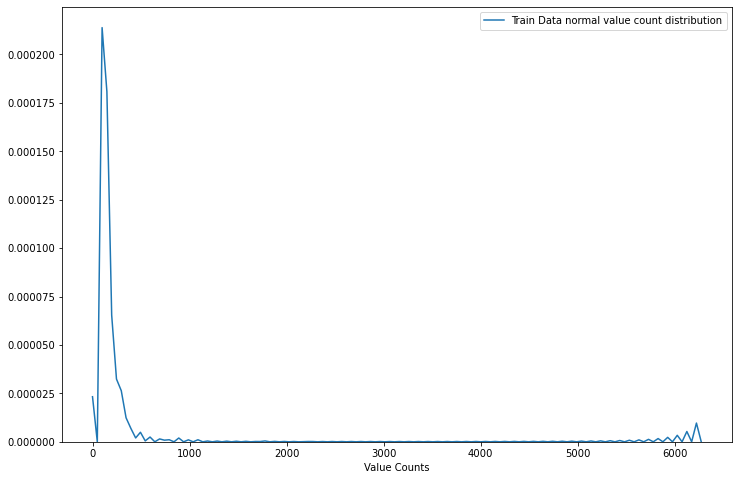

In [5]:
# Train Dataset Default Summary
print(train_data.head())
print(train_data.shape)

# Show default distribution of value_counts - ! Class Imbalance
train_value_counts_regular = train_data['landmark_id'].value_counts()
plt.figure(figsize=(12, 8))
sns.distplot(train_value_counts_regular, hist = False, rug = False, label = "Train Data normal value count distribution")
plt.xlabel("Value Counts")
plt.show()

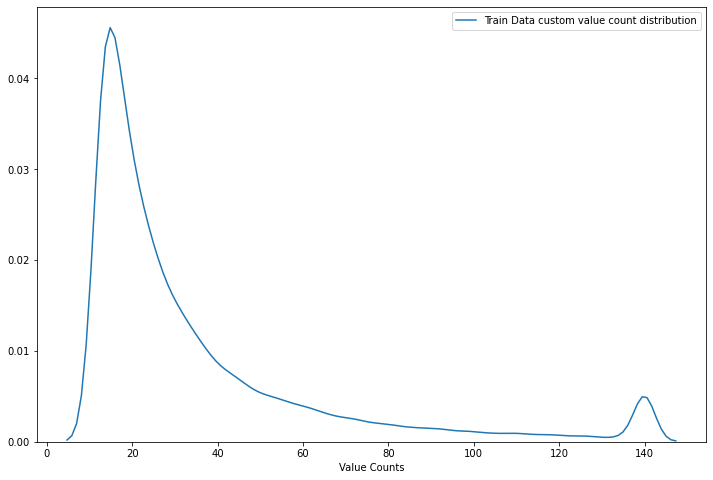

In [6]:
# Subsample Train.csv
def custom_sampler(df, min_samples, max_samples):
    landmark_id_counts = df['landmark_id'].value_counts()

    # First get part of data set between min_samples and max_samples
    df1 = df[df['landmark_id'].isin(landmark_id_counts[(landmark_id_counts >= min_samples) & (landmark_id_counts <= max_samples)].index)]
    
    # Next for all Landmark_ids that have higher than max_samples sample count...down sample to max_samples
    for id in landmark_id_counts[landmark_id_counts > max_samples].index:
        # Get max_samples for specific landmark_id
        temp_df = df[df.landmark_id == id].sample(max_samples, random_state = SEED)

        # Concatenate Dataframes
        df1 = pd.concat([df1, temp_df], axis = 0)
        
    return df1

# Perform Custom datasampling on Train.csv
# Only use Labels that have a minimum of min_samples in images.
# Any Label that has more images than max_samples...downsample to the amount of max_samples
train_data = custom_sampler(train_data, min_samples = 12, max_samples = 140)

# New Distribution - Class Imbalance is smaller
train_value_counts_custom = train_data['landmark_id'].value_counts()
plt.figure(figsize=(12, 8))
sns.distplot(train_value_counts_custom, hist = False, rug = False, label = "Train Data custom value count distribution")
plt.xlabel("Value Counts")
plt.show() 

In [7]:
# Get all unique landmark_ids
all_landmark_ids = train_data.landmark_id.unique().tolist()
print(f'Total number of classes sampled: {len(all_landmark_ids)}')

# Get All Labels for One-Hot
ALL_LABELS = np.sort(np.unique(all_landmark_ids))
lb = LabelBinarizer(sparse_output = True)
lb.fit(ALL_LABELS)

Total number of classes sampled: 34045


LabelBinarizer(sparse_output=True)

In [8]:
def batch_gap(y_t, y_p):
    pred_cat = tf.argmax(y_p, axis=-1)    
    y_t_cat = tf.argmax(y_t, axis=-1) * tf.cast(
        tf.reduce_sum(y_t, axis=-1), tf.int64)
    
    n_pred = tf.shape(pred_cat)[0]
    is_c = tf.cast(tf.equal(pred_cat, y_t_cat), tf.float32)

    GAP = tf.reduce_mean(
          tf.cumsum(is_c) * is_c / tf.cast(
              tf.range(1, n_pred + 1), 
              dtype=tf.float32))
    
    return GAP

# Modelcheckpoint Callback
def ModelCheckpoint():
    return tf.keras.callbacks.ModelCheckpoint(
                            'Model_epoch{epoch:02d}_vl{val_loss:.4f}_va{val_acc:.4f}_vbg{val_batch_gap:.4f}.h5', 
                            monitor = 'val_loss', 
                            verbose = 1, 
                            save_best_only = False, 
                            save_weights_only = True, 
                            mode = 'min', 
                            save_freq = 'epoch')

# Generalized mean pool - GeM
def generalized_mean_pool_2d(X):
    gm_exp = 3.0
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                        axis = [1, 2], 
                        keepdims = False) + 1.e-7)**(1./gm_exp)
    return pool

# I've also put in a model with a GeM layer. Given enough compute time a model with a GeM layer will likely score higher.
def create_model_gem(WEIGHTS, CLASSES): 
    # Input Layer
    input = tf.keras.layers.Input(shape = SHAPE)
    
    # Create and Compile Model and show Summary
    effnet_model = efn.EfficientNetB2(weights = WEIGHTS, include_top = False, input_tensor = input, pooling = None , classes = None)
        
    X = tf.keras.layers.Lambda(generalized_mean_pool_2d, name = 'gem')(effnet_model.output)
    X = tf.keras.layers.Dropout(0.25)(X)
    X = tf.keras.layers.Dense(1024, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dropout(0.25)(X)
    preds = tf.keras.layers.Dense(CLASSES, activation = 'softmax')(X)
    
    # Create Final Model
    model = tf.keras.Model(inputs = effnet_model.input, outputs = preds)

    # UnFreeze all layers
    for layer in model.layers:
        layer.trainable = True
    
    return model

def create_model(WEIGHTS, CLASSES): 
    # Input Layer
    input = tf.keras.layers.Input(shape = SHAPE)
    
    # Create and Compile Model and show Summary
    effnet_model = efn.EfficientNetB2(weights = WEIGHTS, include_top = False, input_tensor = input, pooling = 'avg', classes = None)
    
    X = tf.keras.layers.Dropout(0.25)(effnet_model.output)
    X = tf.keras.layers.Dense(1024, activation = 'relu')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dropout(0.25)(X)
    preds = tf.keras.layers.Dense(CLASSES, activation = 'softmax')(X)
    
    # Create Final Model
    model = tf.keras.Model(inputs = effnet_model.input, outputs = preds)

    # UnFreeze all layers
    for layer in model.layers:
        layer.trainable = True
    
    return model

In [9]:
if not INFERENCE:
    # Randomize Data
    train_data = train_data.sample(frac = 1, random_state = SEED)

    # Create Landmark Prediction Model
    model = create_model('imagenet', len(all_landmark_ids))

    # Compile Model
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1)
    optimizer = tf.keras.optimizers.Adam(lr = LR)
    model.compile(loss = loss, optimizer = optimizer, metrics = ['acc', batch_gap])
    
    # Model Summary
    #print(model.summary())

    # Stratified Train Test Split
    idsTrain, idsVal, labelsTrain, labelsVal = train_test_split(train_data.id.tolist(), 
                                                                lb.transform(train_data.landmark_id), 
                                                                test_size = TEST_SIZE, 
                                                                random_state = SEED, 
                                                                stratify = train_data.landmark_id)

    # Create Data Generators for Train and Valid
    data_generator_train = TrainDataGenerator(image_ids = idsTrain,
                                            labels = labelsTrain, 
                                            classes = len(ALL_LABELS),
                                            batch_size = BATCH_SIZE,
                                            augmentation = True)
    data_generator_val = TrainDataGenerator(image_ids = idsVal,
                                            labels = labelsVal,
                                            classes = len(ALL_LABELS),
                                            batch_size = 2 * BATCH_SIZE,
                                            augmentation = False)

    TRAIN_STEPS = int(len(data_generator_train))
    VALID_STEPS = int(len(data_generator_val))
    print('Train Generator Size: {0}'.format(len(data_generator_train)))
    print('Validation Generator Size: {0}'.format(len(data_generator_val)))

    history = model.fit_generator(generator = data_generator_train,
                        validation_data = data_generator_val,
                        steps_per_epoch = TRAIN_STEPS,
                        validation_steps = VALID_STEPS,
                        epochs = 6,
                        callbacks = [ModelCheckpoint()],
                        verbose = 1)

In [10]:
if INFERENCE:    
    def create_image_tta(im_res):
        # Flip Image Left-Right
        im_res_lr = np.fliplr(im_res)
        
        return np.stack((im_res, im_res_lr))  

    # Create Landmark Prediction Model
    model = create_model(None, len(all_landmark_ids))

    # Reload Weights
    model.load_weights('../input/glrec2020/Model_epoch06_vl3.2417_va0.6774_vbg0.4803.h5')
    
    if PLACES:
        # Places365 Model
        model_places = VGG16_Places365(weights = '../input/keras-vgg16-places365/vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5')
        predictions_to_return = 6
        places_classes = pd.read_csv('../input/keras-vgg16-places365/categories_places365_extended_v1.csv')
        
    print('Start Creating Submission...')
    prediction = []
    
    for index, row in tqdm(submission.iterrows(), total = submission.shape[0]):
        # Image Id
        image_id = row['id']

        # Get full file path
        file_name = f"{TEST_ROOT_PATH}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.jpg"

        # Read and resize image
        image = read_image(file_name, SIZE, normalize_image = True)

        if PLACES:
            # Read and resize image. For the Places Model I use a fixed size.
            image_places = read_image(file_name, 224, normalize_image = False)

            # Identify Indoor/Outdoor with Places365
            places_preds = model_places.predict(create_image_tta(image_places))
            places_pred = np.mean(places_preds, axis = 0)
            places_top_preds = np.argsort(places_pred)[::-1][0:predictions_to_return]
            
            # Reset nonlandmark counter
            counter = 0

            # Get the Indoor/Outdoor Marker for the first 4 predictions. 
            # Update counter+1 if marker is NonLandmark      
            if (places_classes.loc[places_classes['class'] == places_top_preds[0]].io == 1).bool():
                counter +=1
            if (places_classes.loc[places_classes['class'] == places_top_preds[1]].io == 1).bool():
                counter +=1
            if (places_classes.loc[places_classes['class'] == places_top_preds[2]].io == 1).bool():
                counter +=1
            if (places_classes.loc[places_classes['class'] == places_top_preds[3]].io == 1).bool():
                counter +=1

            # Get Predictions for Landmarks
            if counter >= 3:
                prediction.append(' ')                    
            else:
                pred = model.predict(create_image_tta(image))
                max_value = np.max(np.mean(pred, axis = 0))
                max_index = np.argmax(np.mean(pred, axis = 0))
                prediction.append(str(ALL_LABELS[max_index]) + ' ' + str(max_value))
        else:
            pred = model.predict(create_image_tta(image))
            max_value = np.max(np.mean(pred, axis = 0))
            max_index = np.argmax(np.mean(pred, axis = 0))
            prediction.append(str(ALL_LABELS[max_index]) + ' ' + str(max_value))
            
    # Create Submission CSV
    submission['landmarks'] = np.array(prediction)
    submission.to_csv('submission.csv', index = False)

    # Show Summary
    print(submission.head(25))

Start Creating Submission...



                  id          landmarks
0   00084cdf8f600d00   159483 0.9450343
1   000b15b043eb8cf0                   
2   0011a52f9b948fd2                   
3   00141b8a5a729084     4406 0.1416435
4   0018aa4b92532b77                   
5   001baaaab791d8db                   
6   002bc16418269c3d   6208 0.105002806
7   0043158ee252596c                   
8   00441c9ba2d68ce4   57116 0.29259682
9   0044d82ea7654ece   22363 0.41546354
10  004f3afc1377b6fb   87237 0.27189934
11  004fba3dc75efae7                   
12  0065fe4125634e9c                   
13  006c3aaa4f75b6c4                   
14  00779bb62b0a3387                   
15  0087f2ac45a2244f                   
16  0089378b1d5d278a  151358 0.11016494
17  008e86554b3d09bd    57004 0.2276597
18  0093ec8e65398bcb                   
19  009713af66b57b09                   
20  00a2954c0d5954ca                   
21  00a3a6ba9065d42b   42858 0.13870476
22  00acc93c3633d496                   
23  00aecdf67eba413a                   